# Load data


In [2]:
# Load data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path
from glob import glob

# Блок 1. Загрузка данных
base_path = '/kaggle/input/arc-prize-2024/'

# Загрузка JSON данных
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')
test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')

# Data analysis

In [3]:
# Определение цветовой карты (RGBA), но без альфа-канала
base_color_map = {
    0: (0, 0, 0),          # black
    1: (0, 116, 217),      # blue
    2: (255, 65, 54),      # red
    3: (46, 204, 64),      # green
    4: (255, 220, 0),      # yellow
    5: (170, 170, 170),    # gray
    6: (240, 18, 190),     # magenta
    7: (255, 133, 27),     # orange
    8: (127, 219, 255),    # sky blue
    9: (135, 12, 37)       # brown
}

def colorize_cell(value, alpha=0.3):
    """
    Функция для раскрашивания ячейки в зависимости от значения
    с возможностью настройки прозрачности через параметр alpha.
    """
    color = base_color_map.get(value, (255, 255, 255))  # Белый по умолчанию
    rgba_color = f'rgba({color[0]}, {color[1]}, {color[2]}, {alpha})'
    return f'background-color: {rgba_color}'

# Блок 2. Функция для отображения задачи и решений
def plot_task(task, task_solutions, task_id, alpha=0.3):
    """Визуализация задачи в виде графика и текстового представления"""
    
    num_train = len(task['train'])
    num_test  = len(task['test'])
    
    w = num_train + num_test
    fig, axs  = plt.subplots(2, w, figsize=(3 * w, 3 * 2))
    plt.suptitle(f'Set #{task_id}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):     
        plot_one(axs[0, j], task, j, 'train', 'input')
        plot_one(axs[1, j], task, j, 'train', 'output')        
    
    plot_one(axs[0, num_train], task, 0, 'test', 'input')

    answer = task_solutions
    input_matrix = answer
    
    axs[1, num_train].imshow(input_matrix, cmap=cmap, norm=norm)
    axs[1, num_train].grid(True, which='both', color='lightgrey', linewidth=0.5)
    axs[1, num_train].set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    axs[1, num_train].set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])     
    axs[1, num_train].set_xticklabels([])
    axs[1, num_train].set_yticklabels([])
    axs[1, num_train].set_title('Test output')

    plt.tight_layout()
    plt.show()  

    # Текстовое представление данных через Pandas DataFrame с раскрашиванием
    print(f"Текстовое представление задачи #{task_id}:")
    for j in range(num_train):
        df_input = pd.DataFrame(task['train'][j]['input'])
        df_output = pd.DataFrame(task['train'][j]['output'])
        print(f"--- Train {j + 1} Input ---")
        display(df_input.style.map(lambda v: colorize_cell(v, alpha=alpha)))
        print(f"--- Train {j + 1} Output ---")
        display(df_output.style.map(lambda v: colorize_cell(v, alpha=alpha)))
    
    df_test_input = pd.DataFrame(task['test'][0]['input'])
    print(f"--- Test Input ---")
    display(df_test_input.style.map(lambda v: colorize_cell(v, alpha=alpha)))

    df_test_output = pd.DataFrame(task_solutions)
    print(f"--- Expected Test Output ---")
    display(df_test_output.style.map(lambda v: colorize_cell(v, alpha=alpha)))

def plot_one(ax, task, i, train_or_test, input_or_output):
    """Визуализация одного примера"""
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(train_or_test + ' ' + input_or_output)

# Блок 3. Извлечение данных для использования в нейросети
def extract_data_for_nn(task_id, dataset_type='train'):
    """Извлечение данных для использования в нейросети"""
    if dataset_type == 'train':
        task = training_challenges[task_id]
        task_solution = training_solutions[task_id][0]
    elif dataset_type == 'eval':
        task = evaluation_challenges[task_id]
        task_solution = evaluation_solutions[task_id][0]
    else:
        task = test_challenges[task_id]
        task_solution = None  # Нет решения для тестовых данных
    
    # Извлечение данных в формате: (входы, выходы)
    train_inputs = [np.array(task['train'][i]['input']) for i in range(len(task['train']))]
    train_outputs = [np.array(task['train'][i]['output']) for i in range(len(task['train']))]
    
    test_input = np.array(task['test'][0]['input'])
    test_output = np.array(task_solution) if task_solution else None

    return train_inputs, train_outputs, test_input, test_output

# Блок 4. Вызов задачи по ID и визуализация
def plot_task_by_id(task_id, dataset_type='train', alpha=0.3):
    """Отображение задачи по её ID"""
    if dataset_type == 'train':
        task = training_challenges[task_id]
        task_solution = training_solutions[task_id][0]
    elif dataset_type == 'eval':
        task = evaluation_challenges[task_id]
        task_solution = evaluation_solutions[task_id][0]
    else:
        task = test_challenges[task_id]
        task_solution = None  # Нет решения для тестовых данных

    plot_task(task, task_solution, task_id, alpha=alpha)

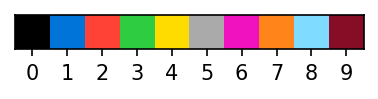

In [4]:
# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

plt.figure(figsize=(3, 1), dpi=150)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

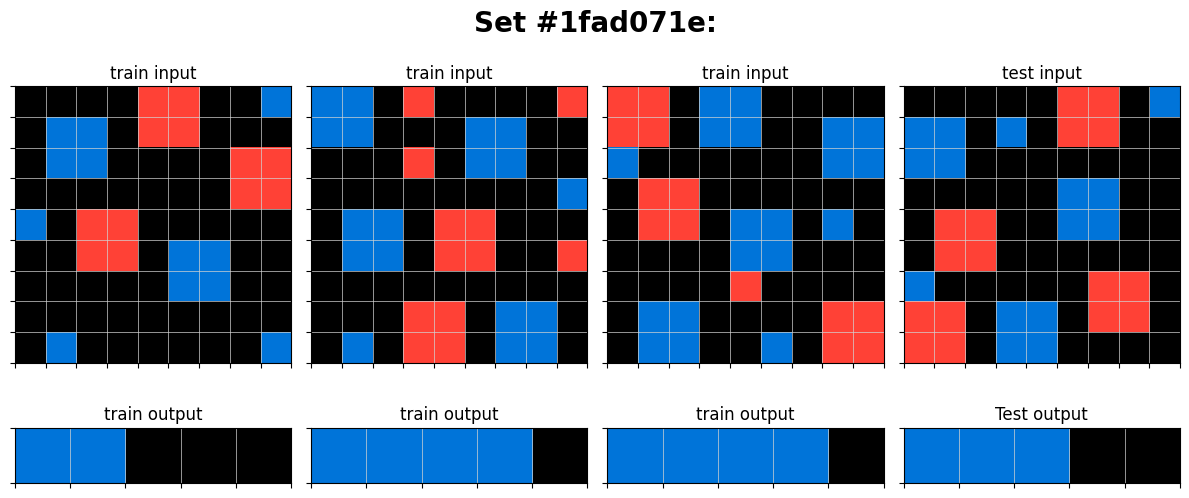

Текстовое представление задачи #1fad071e:
--- Train 1 Input ---


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,2,2,0,0,1
1,0,1,1,0,2,2,0,0,0
2,0,1,1,0,0,0,0,2,2
3,0,0,0,0,0,0,0,2,2
4,1,0,2,2,0,0,0,0,0
5,0,0,2,2,0,1,1,0,0
6,0,0,0,0,0,1,1,0,0
7,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,1


--- Train 1 Output ---


,0,1,2,3,4
0,1,1,0,0,0


--- Train 2 Input ---


,0,1,2,3,4,5,6,7,8
0,1,1,0,2,0,0,0,0,2
1,1,1,0,0,0,1,1,0,0
2,0,0,0,2,0,1,1,0,0
3,0,0,0,0,0,0,0,0,1
4,0,1,1,0,2,2,0,0,0
5,0,1,1,0,2,2,0,0,2
6,0,0,0,0,0,0,0,0,0
7,0,0,0,2,2,0,1,1,0
8,0,1,0,2,2,0,1,1,0


--- Train 2 Output ---


,0,1,2,3,4
0,1,1,1,1,0


--- Train 3 Input ---


,0,1,2,3,4,5,6,7,8
0,2,2,0,1,1,0,0,0,0
1,2,2,0,1,1,0,0,1,1
2,1,0,0,0,0,0,0,1,1
3,0,2,2,0,0,0,0,0,0
4,0,2,2,0,1,1,0,1,0
5,0,0,0,0,1,1,0,0,0
6,0,0,0,0,2,0,0,0,0
7,0,1,1,0,0,0,0,2,2
8,0,1,1,0,0,1,0,2,2


--- Train 3 Output ---


,0,1,2,3,4
0,1,1,1,1,0


--- Test Input ---


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,2,2,0,1
1,1,1,0,1,0,2,2,0,0
2,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0
4,0,2,2,0,0,1,1,0,0
5,0,2,2,0,0,0,0,0,0
6,1,0,0,0,0,0,2,2,0
7,2,2,0,1,1,0,2,2,0
8,2,2,0,1,1,0,0,0,0


--- Expected Test Output ---


,0,1,2,3,4
0,1,1,1,0,0


In [5]:
# Пример вызова задачи по ID с настройкой прозрачности
task_id = "1fad071e"
plot_task_by_id(task_id, alpha=0.8)  # Пример с прозрачностью 0.5

# Извлечение данных для использования в нейросети
train_inputs, train_outputs, test_input, test_output = extract_data_for_nn(task_id)




In [6]:
display('train_inputs', train_inputs, 'train_outputs',train_outputs)

'train_inputs'

[array([[0, 0, 0, 0, 2, 2, 0, 0, 1],
        [0, 1, 1, 0, 2, 2, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 2, 2],
        [1, 0, 2, 2, 0, 0, 0, 0, 0],
        [0, 0, 2, 2, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1]]),
 array([[1, 1, 0, 2, 0, 0, 0, 0, 2],
        [1, 1, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 2, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 2, 2, 0, 0, 0],
        [0, 1, 1, 0, 2, 2, 0, 0, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 2, 0, 1, 1, 0],
        [0, 1, 0, 2, 2, 0, 1, 1, 0]]),
 array([[2, 2, 0, 1, 1, 0, 0, 0, 0],
        [2, 2, 0, 1, 1, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 2, 2, 0, 0, 0, 0, 0, 0],
        [0, 2, 2, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 2, 2],
        [0, 1, 1, 0, 0, 1, 0, 2, 2

'train_outputs'

[array([[1, 1, 0, 0, 0]]), array([[1, 1, 1, 1, 0]]), array([[1, 1, 1, 1, 0]])]

# Create additional dataset

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def resize_matrix(matrix, target_size=(10, 10)):
    """
    Приводит любую матрицу (квадратную или прямоугольную) к заданному размеру (target_size)
    с сохранением структуры данных путем масштабирования (интерполяции).
    
    Parameters:
    matrix (np.ndarray): исходная матрица любого размера (квадратная или прямоугольная)
    target_size (tuple): целевой размер, по умолчанию (10, 10)
    
    Returns:
    np.ndarray: матрица размера target_size
    """
    current_size = matrix.shape
    row_zoom = target_size[0] / current_size[0]
    col_zoom = target_size[1] / current_size[1]
    
    resized_matrix = zoom(matrix, (row_zoom, col_zoom))
    
    return resized_matrix

def reverse_resize_matrix(matrix, original_size):
    """
    Возвращает матрицу к её исходному размеру (original_size) путем обратного масштабирования.
    
    Parameters:
    matrix (np.ndarray): матрица, которую нужно восстановить
    original_size (tuple): исходный размер матрицы
    
    Returns:
    np.ndarray: матрица исходного размера
    """
    current_size = matrix.shape
    row_zoom = original_size[0] / current_size[0]
    col_zoom = original_size[1] / current_size[1]
    
    restored_matrix = zoom(matrix, (row_zoom, col_zoom))
    
    return restored_matrix

In [125]:
import numpy as np
import random

def generate_random_matrix(min_size=1, max_size=32):
    """
    Генерирует матрицу случайного размера от min_size до max_size
    со значениями от 0 до 9.
    
    Parameters:
    min_size (int): минимальный размер матрицы
    max_size (int): максимальный размер матрицы
    
    Returns:
    np.ndarray: случайная матрица произвольного размера
    tuple: размеры сгенерированной матрицы
    """
    rows = random.randint(min_size, max_size)
    cols = random.randint(min_size, max_size)
    matrix = np.random.randint(0, 10, size=(rows, cols))  # Генерация значений от 0 до 9
    return matrix, (rows, cols)

def generate_dataset(num_matrices, min_size=1, max_size=32):
    """
    Генерирует набор данных из случайных матриц разных размеров.
    
    Parameters:
    num_matrices (int): количество матриц для генерации
    min_size (int): минимальный размер матрицы
    max_size (int): максимальный размер матрицы
    
    Returns:
    list of tuples: список сгенерированных матриц и их размеров
    """
    dataset = []
    for _ in range(num_matrices):
        matrix, size = generate_random_matrix(min_size, max_size)
        dataset.append((matrix, size))
    return dataset

# Генерация  матриц
num_matrices = 50000  # Количество матриц в наборе данных
dataset = generate_dataset(num_matrices)

# Набор данных сгенерирован


# Scaling and creating train_data, val_data

In [126]:
from sklearn.model_selection import train_test_split

# Используем ранее сгенерированный dataset из матриц
# Нам нужно прогнать их через функцию, чтобы все изображения стали 32x32

def scale_to_size(matrix, target_size=(32, 32)):
    """
    Приводит матрицу к заданному размеру target_size (например, 32x32) с сохранением структуры данных.
    
    Parameters:
    matrix (np.ndarray): исходная матрица
    target_size (tuple): целевой размер
    
    Returns:
    np.ndarray: матрица размера target_size
    """
    original_size = matrix.shape
    target_rows, target_cols = target_size
    
    # Создаем пустую матрицу для результата
    resized_matrix = np.zeros((target_rows, target_cols))
    
    # Вычисляем коэффициенты масштабирования
    row_scale = original_size[0] / target_rows
    col_scale = original_size[1] / target_cols
    
    # Заполняем новую матрицу значениями из старой, пересчитывая индексы
    for i in range(target_rows):
        for j in range(target_cols):
            orig_i = int(i * row_scale)
            orig_j = int(j * col_scale)
            resized_matrix[i, j] = matrix[orig_i, orig_j]
    
    return resized_matrix

# Прогоняем все матрицы через функцию для приведения их к 32x32
processed_dataset = [scale_to_size(matrix) for matrix, _ in dataset]

# Преобразуем в нужный формат для дальнейшей работы
processed_dataset = np.array(processed_dataset).reshape(-1, 1, 32, 32)

# Разделение данных на тренировочную и валидационную выборки (80% на тренировочную)
train_data, val_data = train_test_split(processed_dataset, test_size=0.2, random_state=42)

# Проверка количества данных
len(train_data), len(val_data)  # Выводим количество тренировочных и валидационных данных


(40000, 10000)

## Examples 32*32 matrix 

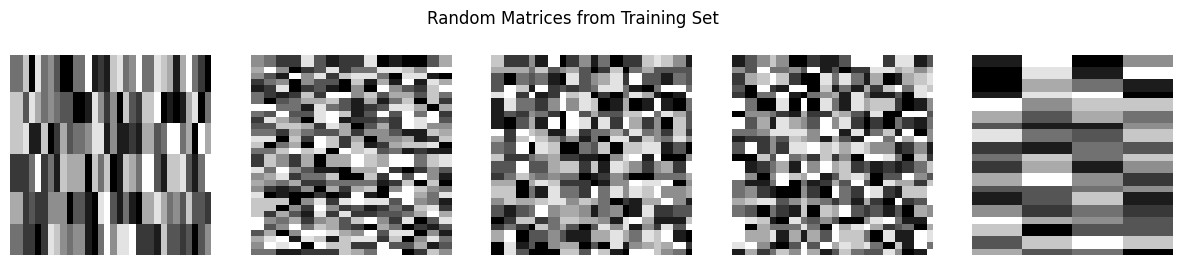

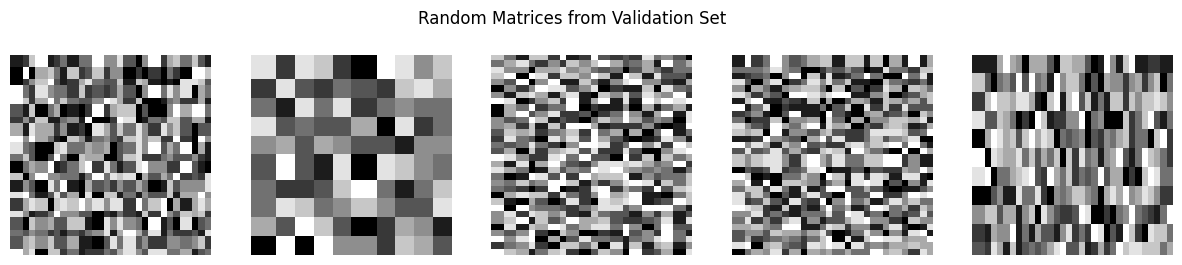

In [127]:
# Выводим несколько случайных матриц из тренировочного и валидационного наборов
import matplotlib.pyplot as plt

def plot_random_matrices(data, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)
    for i in range(5):
        random_idx = np.random.randint(0, len(data))
        axs[i].imshow(data[random_idx][0], cmap='gray')
        axs[i].axis('off')
    plt.show()

# Выводим случайные матрицы из тренировочного набора
plot_random_matrices(train_data, "Random Matrices from Training Set")

# Выводим случайные матрицы из валидационного набора
plot_random_matrices(val_data, "Random Matrices from Validation Set")


## Scalling exemples

In [60]:
from sklearn.model_selection import train_test_split

# Используем ранее сгенерированный dataset из матриц
# Нам нужно прогнать их через функцию, чтобы все изображения стали 32x32

def scale_to_size(matrix, target_size=(32, 32)):
    """
    Приводит матрицу к заданному размеру target_size (например, 32x32) с сохранением структуры данных.
    
    Parameters:
    matrix (np.ndarray): исходная матрица
    target_size (tuple): целевой размер
    
    Returns:
    np.ndarray: матрица размера target_size
    """
    original_size = matrix.shape
    target_rows, target_cols = target_size
    
    # Создаем пустую матрицу для результата
    resized_matrix = np.zeros((target_rows, target_cols))
    
    # Вычисляем коэффициенты масштабирования
    row_scale = original_size[0] / target_rows
    col_scale = original_size[1] / target_cols
    
    # Заполняем новую матрицу значениями из старой, пересчитывая индексы
    for i in range(target_rows):
        for j in range(target_cols):
            orig_i = int(i * row_scale)
            orig_j = int(j * col_scale)
            resized_matrix[i, j] = matrix[orig_i, orig_j]
    
    return resized_matrix

# Прогоняем все матрицы через функцию для приведения их к 32x32
processed_dataset = [scale_to_size(matrix) for matrix, _ in [(array, array.shape) for array in train_inputs]]

# Преобразуем в нужный формат для дальнейшей работы
train_ex = np.array(processed_dataset).reshape(-1, 1, 32, 32)

# Разделение данных на тренировочную и валидационную выборки (80% на тренировочную)
# train_ex, val_ex = train_test_split(processed_dataset, test_size=0.2, random_state=42)

# Проверка количества данных
len(train_ex)


3

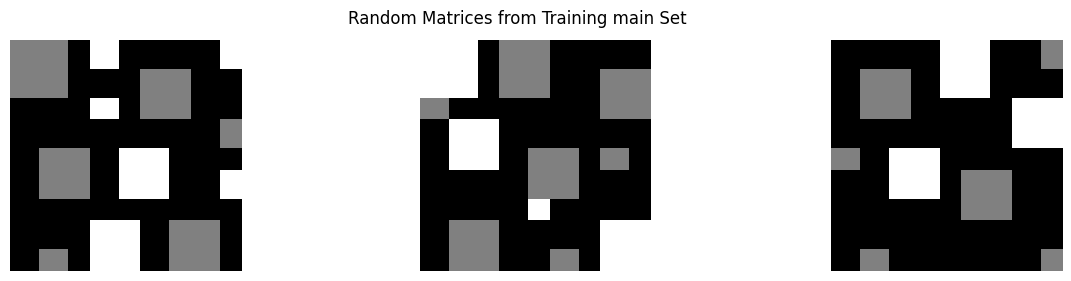

In [63]:
# Выводим несколько случайных матриц из тренировочного и валидационного наборов
import matplotlib.pyplot as plt

def plot_random_matrices(data, title):
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    fig.suptitle(title)
    for i in range(3):
        random_idx = np.random.randint(0, len(data))
        axs[i].imshow(data[random_idx][0], cmap='gray')
        axs[i].axis('off')
    plt.show()

# Выводим случайные матрицы из тренировочного набора
plot_random_matrices(train_ex, "Random Matrices from Training main Set")



In [20]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    print("GPU доступен")
else:
    print("GPU НЕ доступен")

GPU доступен


# VAE

Исходная форма train_data: (40000, 1, 32, 32)
Исходная форма val_data: (10000, 1, 32, 32)
Удаление лишних измерений из train_data...
Форма train_data после squeeze: (40000, 32, 32)
Удаление лишних измерений из val_data...
Форма val_data после squeeze: (10000, 32, 32)
Форма train_data после добавления канала: (40000, 32, 32, 1)
Форма val_data после добавления канала: (10000, 32, 32, 1)
Форма train_data перед fit: (40000, 32, 32, 1)
Форма val_data перед fit: (10000, 32, 32, 1)


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_475 (Conv2D)             │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_124 (LeakyReLU)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_367         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_476 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_125 (LeakyReLU)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_368         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_111               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_477 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_126 (LeakyReLU)     │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_369         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_112               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_478 (Conv2D)             │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_127 (LeakyReLU)     │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_370         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 2, 2, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 2, 2, 256)      │             

 Total params: 3,468,545 (13.23 MB)

 Trainable params: 3,466,625 (13.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 0.1065 - val_loss: 0.1017 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0904 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0820 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0760 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0708 - val_loss: 0.0727 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0659 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0620 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0591 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0570 - val_loss: 0.0604 - learning_rate: 0.0010


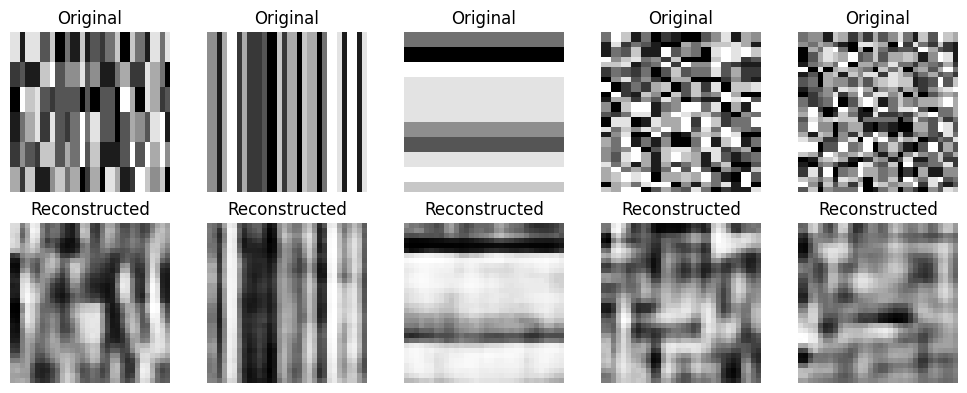

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0556 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0544 - val_loss: 0.0579 - learning_rate: 0.0010
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0532 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0521 - val_loss: 0.0554 - learning_rate: 0.0010
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0510 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0500 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0489 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 17/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0478 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0468 - val_loss: 0.0502 - learning_rate: 0.0010
Epoc

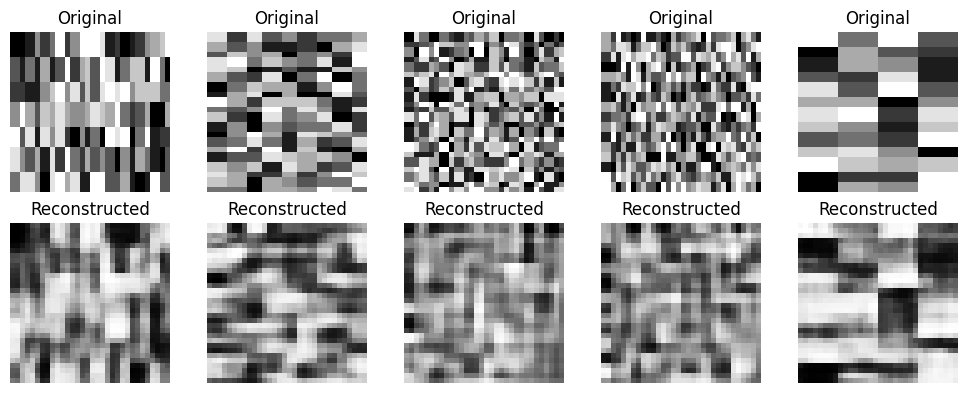

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0448 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 21/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0438 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 22/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0429 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 23/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0420 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0411 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 25/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0403 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 26/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0396 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 27/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0389 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 28/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0383 - val_loss: 0.0429 - learning_rate: 0.0010
Epoc

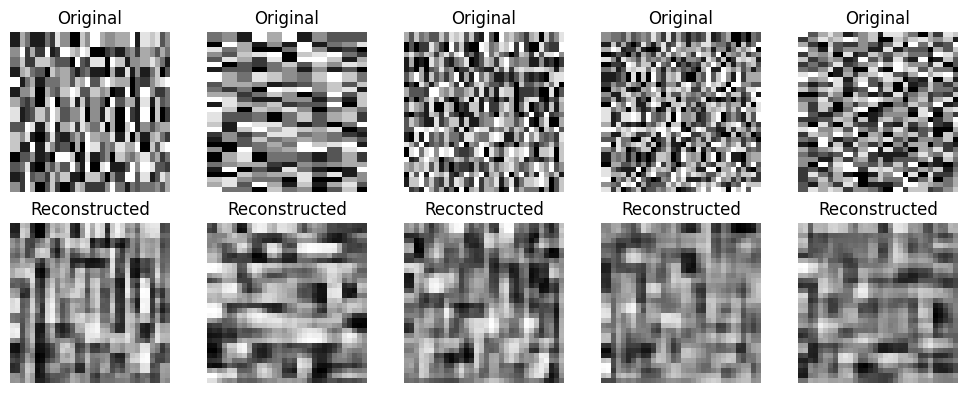

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0371 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 31/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0365 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 32/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0359 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 33/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0353 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 34/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0348 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 35/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0343 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 36/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0338 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 37/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0335 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 38/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0330 - val_loss: 0.0375 - learning_rate: 0.0010
Epoc

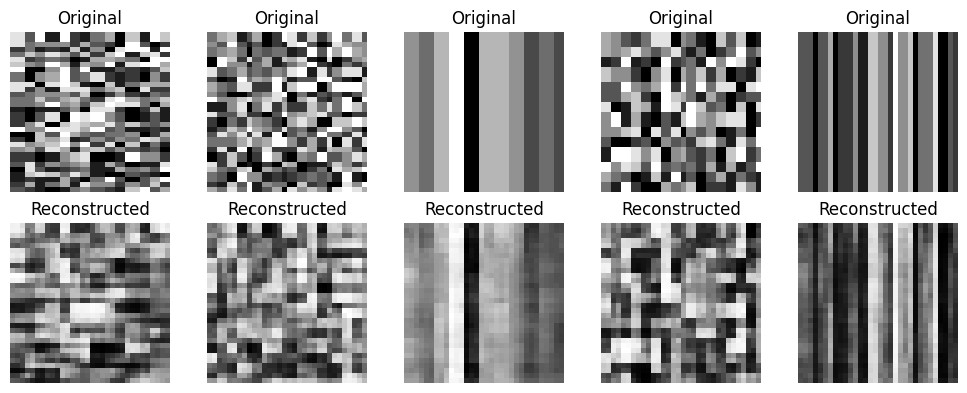

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0322 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 41/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0319 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 42/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0315 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 43/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0311 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 44/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0308 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 45/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0304 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 46/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0302 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 47/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0299 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 48/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0296 - val_loss: 0.0331 - learning_rate: 0.0010
Epoc

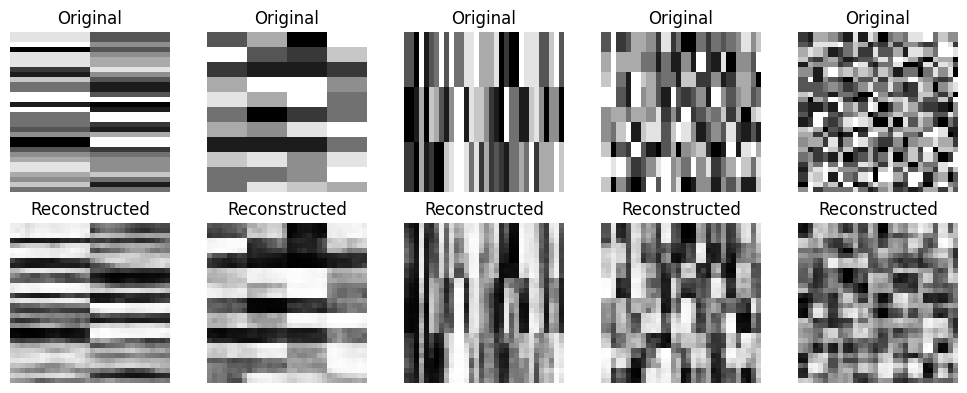

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0291 - val_loss: 0.0325 - learning_rate: 0.0010


In [133]:
# ============================================
# Шаг 0: Установка и Импорт Необходимых Библиотек
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Flatten, Dense, Reshape, BatchNormalization, LeakyReLU, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard

# Включение миксированной точности (если поддерживается GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ============================================
# Шаг 1: Настройка Параметров Обучения
# ============================================

# Параметры модели
input_shape = (32, 32, 1)      # Форма входных данных
embedding_dim = 1024            # Размер эмбеддинга

# Параметры обучения
batch_size = 256               # Размер батча
epochs = 50                 # Общее количество эпох
learning_rate = 1e-3           # Уменьшенная скорость обучения

# Параметры колбэков
display_freq = 25              # Частота отображения графиков (в эпохах)
num_display_images = 5         # Количество изображений для отображения

# ============================================
# Шаг 2: Подготовка Данных
# ============================================

# Предполагается, что train_data и val_data уже загружены как numpy массивы формы (num_samples, 32, 32)
# Пример загрузки данных:
# train_data = np.load('path_to_train_data.npy')
# val_data = np.load('path_to_val_data.npy')

# Проверка исходной формы данных
print("Исходная форма train_data:", train_data.shape)
print("Исходная форма val_data:", val_data.shape)

# Удаление лишних измерений, если они есть
def preprocess_data(data, name='data'):
    if len(data.shape) > 3:
        print(f"Удаление лишних измерений из {name}...")
        data = np.squeeze(data)
        print(f"Форма {name} после squeeze:", data.shape)
    return data

train_data = preprocess_data(train_data, 'train_data')
val_data = preprocess_data(val_data, 'val_data')

# Нормализация данных до диапазона [0, 1]
train_data = train_data.astype('float32') / 9.0
val_data = val_data.astype('float32') / 9.0

# Добавление канала, чтобы данные имели форму (num_samples, 32, 32, 1)
def add_channel(data, name='data'):
    if len(data.shape) == 2:
        # Если данные имеют форму (32, 32), добавляем размерность канала
        data = np.expand_dims(data, axis=-1)
        print(f"Форма {name} после добавления канала:", data.shape)
    elif len(data.shape) == 3 and data.shape[-1] != 1:
        # Если данные имеют форму (num_samples, 32, 32) без канала, добавляем канал
        data = np.expand_dims(data, axis=-1)
        print(f"Форма {name} после добавления канала:", data.shape)
    return data

train_data = add_channel(train_data, 'train_data')
val_data = add_channel(val_data, 'val_data')

# Финальная проверка формы данных
print("Форма train_data перед fit:", train_data.shape)
print("Форма val_data перед fit:", val_data.shape)

# ============================================
# Шаг 3: Построение Модели Автоэнкодера
# ============================================

def build_autoencoder(input_shape, embedding_dim=256):
    input_img = Input(shape=input_shape)
    
    # Энкодер
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Дополнительный свёрточный слой
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Бутылочное горлышко
    x = Flatten()(x)
    encoded = Dense(embedding_dim, activation='relu')(x)
    
    # Декодер
    x = Dense(2 * 2 * 256, activation='relu')(encoded)
    x = Reshape((2, 2, 256))(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    # Выходной слой
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Модель
    autoencoder = Model(inputs=input_img, outputs=decoded)
    return autoencoder

# Инициализация модели
autoencoder = build_autoencoder(input_shape, embedding_dim=embedding_dim)

# ============================================
# Шаг 4: Компиляция Модели
# ============================================

optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

autoencoder.summary()

# ============================================
# Шаг 5: Настройка Колбэков
# ============================================

# Колбэк для отображения результатов каждые display_freq эпох
class ImageDisplayCallback(Callback):
    def __init__(self, val_data, display_freq=10, num_images=5):
        super(ImageDisplayCallback, self).__init__()
        self.val_data = val_data
        self.display_freq = display_freq
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_freq == 0:
            idx = np.random.randint(0, self.val_data.shape[0], size=self.num_images)
            sample_images = self.val_data[idx]
            reconstructed = self.model.predict(sample_images)
            
            plt.figure(figsize=(10, 4))
            for i in range(self.num_images):
                # Оригинальные изображения
                ax = plt.subplot(2, self.num_images, i + 1)
                plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
                plt.title('Original')
                plt.axis('off')
                
                # Восстановленные изображения
                ax = plt.subplot(2, self.num_images, i + 1 + self.num_images)
                plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

# Планировщик скорости обучения: уменьшение lr после 500 эпох
def scheduler(epoch, lr):
    if epoch > 500:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# TensorBoard для мониторинга обучения
tensorboard = TensorBoard(log_dir='/kaggle/working/logs')

# Инициализация пользовательских колбэков
image_display = ImageDisplayCallback(val_data=val_data, display_freq=display_freq, num_images=num_display_images)
callbacks = [image_display, lr_scheduler, tensorboard]

# ============================================
# Шаг 6: Создание Потока Данных с Использованием tf.data.Dataset
# ============================================

# Создание Dataset для обучения
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Создание Dataset для валидации
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data))
val_dataset = val_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# ============================================
# Шаг 7: Обучение Модели
# ============================================

autoencoder.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks
)

# ============================================
# Шаг 8: Сохранение и Загрузка Модели
# ============================================

# Функция для сохранения модели вручную (опционально)
def save_model_manual(model, save_dir='/kaggle/working/saved_models/'):
    os.makedirs(save_dir, exist_ok=True)  # Создание директории, если не существует
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'autoencoder_{timestamp}.keras'
    filepath = os.path.join(save_dir, filename)
    model.save(filepath)
    print(f'Модель сохранена по пути: {filepath}')

# Функция для загрузки сохранённой модели
def load_saved_model(filepath):
    if os.path.exists(filepath):
        model = load_model(filepath)
        print(f'Модель загружена из: {filepath}')
        return model
    else:
        print(f'Файл модели не найден по пути: {filepath}')
        return None

# ============================================
# Шаг 9: Визуализация Сохранённых Моделей (Опционально)
# ============================================

# Функция для визуализации всех сохранённых моделей
def visualize_saved_models(save_dir='/kaggle/working/saved_models/', num_images=5):
    if not os.path.exists(save_dir):
        print(f"Директория {save_dir} не существует.")
        return
    
    saved_files = sorted([f for f in os.listdir(save_dir) if f.startswith('autoencoder_') and f.endswith('.keras')])
    if not saved_files:
        print(f"В директории {save_dir} нет сохранённых моделей.")
        return
    
    for file in saved_files:
        filepath = os.path.join(save_dir, file)
        model = load_saved_model(filepath)
        if model:
            print(f'Визуализация модели из файла: {file}')
            idx = np.random.randint(0, val_data.shape[0], size=num_images)
            sample_images = val_data[idx]
            reconstructed = model.predict(sample_images)
            
            plt.figure(figsize=(10, 4))
            for i in range(num_images):
                # Оригинальные изображения
                ax = plt.subplot(2, num_images, i + 1)
                plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
                plt.title('Original')
                plt.axis('off')
                
                # Восстановленные изображения
                ax = plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

# Пример использования функции визуализации (можно вызвать после обучения)
# visualize_saved_models()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0392 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0391 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0390 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0388 - val_loss: 0.0637 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0389 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0390 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0387 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0386 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0387 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 10/50
32/32 ━

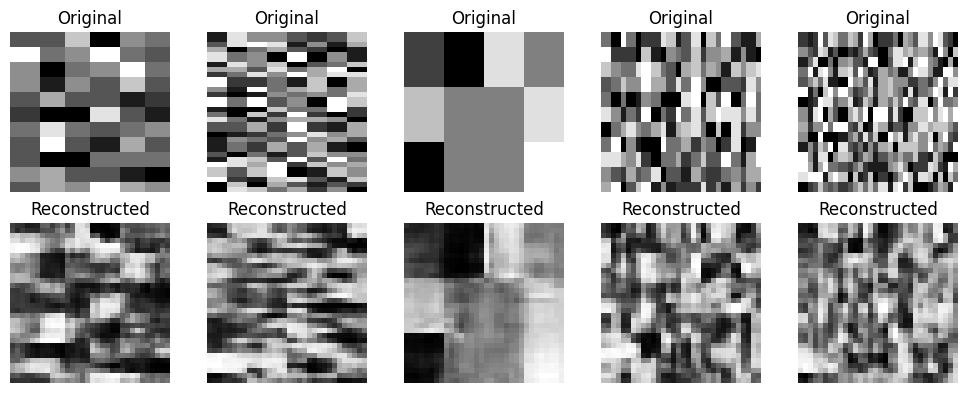

Модель сохранена по пути: /kaggle/working/saved_models/autoencoder_20241025_155258.keras


In [24]:
# ============================================
# Шаг 5: Настройка Колбэков
# ============================================

# Колбэк для отображения результатов один раз после завершения обучения
class FinalImageDisplayCallback(Callback):
    def __init__(self, val_data, num_images=5):
        super(FinalImageDisplayCallback, self).__init__()
        self.val_data = val_data
        self.num_images = num_images

    def on_train_end(self, logs=None):
        idx = np.random.randint(0, self.val_data.shape[0], size=self.num_images)
        sample_images = self.val_data[idx]
        reconstructed = self.model.predict(sample_images)

        plt.figure(figsize=(10, 4))
        for i in range(self.num_images):
            # Оригинальные изображения
            ax = plt.subplot(2, self.num_images, i + 1)
            plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Восстановленные изображения
            ax = plt.subplot(2, self.num_images, i + 1 + self.num_images)
            plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Инициализация пользовательских колбэков
final_image_display = FinalImageDisplayCallback(val_data=val_data, num_images=num_display_images)

# Другие колбэки остаются прежними
callbacks = [final_image_display, lr_scheduler, tensorboard]

# ============================================
# Шаг 7: Продолжение Обучения Модели на 50 Эпох
# ============================================

autoencoder.fit(
    train_dataset,
    epochs=additional_epochs,  # Новые дополнительные эпохи
    validation_data=val_dataset,
    callbacks=callbacks  # Используем обновленные колбэки
)

# ============================================
# Шаг 8: Сохранение дообученной модели (опционально)
# ============================================

save_model_manual(autoencoder)


In [50]:
from tensorflow.keras.models import save_model
from datetime import datetime

# Функция для сохранения модели вручную с временной меткой
def save_model_manual(model, save_dir='/kaggle/working/'):
    os.makedirs(save_dir, exist_ok=True)  # Создание директории, если не существует
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'autoencoder_{timestamp}.keras'
    filepath = os.path.join(save_dir, filename)
    model.save(filepath)
    print(f'Модель сохранена по пути: {filepath}')

# Пример сохранения модели
save_model_manual(autoencoder)


Модель сохранена по пути: /kaggle/working/autoencoder_20241024_202957.keras


In [ ]:
from tensorflow.keras.models import load_model

# Функция для загрузки сохранённой модели
def load_saved_model(filepath):
    if os.path.exists(filepath):
        model = load_model(filepath)
        print(f'Модель загружена из: {filepath}')
        return model
    else:
        print(f'Файл модели не найден по пути: {filepath}')
        return None

# Пример загрузки модели
# Замените 'path_to_model.keras' на путь к вашей сохранённой модели
loaded_autoencoder = load_saved_model('/kaggle/working/saved_models/autoencoder_20241025_155049.keras')

# Если вы планируете продолжить обучение, перекомпилируйте модель
if loaded_autoencoder:
    loaded_autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')


In [ ]:
if loaded_autoencoder:
    additional_epochs = 50          # Дополнительные эпохи для обучения
    initial_epoch = epochs           # Предыдущее количество эпох

    loaded_autoencoder.fit(
        train_dataset,
        epochs=initial_epoch + additional_epochs,
        initial_epoch=initial_epoch,
        validation_data=val_dataset,
        callbacks=callbacks
    )


In [134]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка данных
def load_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
    test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    return (train_images, train_labels), (test_images, test_labels)


# VAE Structured

In [151]:
# ============================================
# Блок 0: Установка и Импорт Необходимых Библиотек
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Flatten, Dense, Reshape, BatchNormalization, LeakyReLU, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard
from datetime import datetime

# Включение миксированной точности (если поддерживается GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [152]:
# ============================================
# Блок 1: Подготовка Модели и Данных
# ============================================

def prepare_data(train_data, val_data):
    """
    Предобработка данных: удаление лишних измерений, нормализация и добавление канала.
    """
    print("Исходная форма train_data:", train_data.shape)
    print("Исходная форма val_data:", val_data.shape)
    
    def preprocess_data(data, name='data'):
        if len(data.shape) > 3:
            print(f"Удаление лишних измерений из {name}...")
            data = np.squeeze(data)
            print(f"Форма {name} после squeeze:", data.shape)
        return data
    
    train_data = preprocess_data(train_data, 'train_data')
    val_data = preprocess_data(val_data, 'val_data')
    
    # Нормализация данных до диапазона [0, 1]
    train_data = train_data.astype('float32') / 9.0
    val_data = val_data.astype('float32') / 9.0
    
    def add_channel(data, name='data'):
        if len(data.shape) == 2:
            # Если данные имеют форму (32, 32), добавляем размерность канала
            data = np.expand_dims(data, axis=-1)
            print(f"Форма {name} после добавления канала:", data.shape)
        elif len(data.shape) == 3 and data.shape[-1] != 1:
            # Если данные имеют форму (num_samples, 32, 32) без канала, добавляем канал
            data = np.expand_dims(data, axis=-1)
            print(f"Форма {name} после добавления канала:", data.shape)
        return data
    
    train_data = add_channel(train_data, 'train_data')
    val_data = add_channel(val_data, 'val_data')
    
    # Финальная проверка формы данных
    print("Форма train_data перед fit:", train_data.shape)
    print("Форма val_data перед fit:", val_data.shape)
    
    return train_data, val_data


## Model

In [182]:
def build_autoencoder(input_shape, embedding_dim=256):
    input_img = Input(shape=input_shape)
    
    # Энкодер
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Дополнительный свёрточный слой
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Бутылочное горлышко
    x = Flatten()(x)
    encoded = Dense(embedding_dim, activation='relu')(x)
    
    # Декодер
    x = Dense(2 * 2 * 256, activation='relu')(encoded)
    x = Reshape((2, 2, 256))(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    # Выходной слой
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Модель
    autoencoder = Model(inputs=input_img, outputs=decoded)
    return autoencoder

In [174]:
# # ============================================
# # Блок 2: Сама Модель (Улучшенная Версия)
# # ============================================

# from tensorflow.keras.layers import (
#     Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
#     BatchNormalization, LeakyReLU
# )
# from tensorflow.keras.models import Model

# def build_autoencoder(input_shape, embedding_dim=256):
#     """
#     Создание улучшенной модели автоэнкодера, оптимизированной для данных 32x32.
#     Архитектура состоит из симметричного энкодера и декодера с использованием
#     свёрточных слоёв и транспонированных свёрток для upsampling.
#     """
#     inputs = Input(shape=input_shape)
    
#     # Энкодер
#     # Блок 1
#     x = Conv2D(32, (3,3), padding='same')(inputs)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(32, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2,2), padding='same')(x)  # Размер: 16x16
    
#     # Блок 2
#     x = Conv2D(64, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(64, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2,2), padding='same')(x)  # Размер: 8x8
    
#     # Блок 3
#     x = Conv2D(128, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(128, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2,2), padding='same')(x)  # Размер: 4x4
    
#     # Бутылочное горлышко
#     x = Conv2D(256, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(256, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     # Здесь можно добавить дополнительный слой, если требуется
#     encoded = x  # Размер: 4x4x256
    
#     # Декодер
#     # Блок 1 декодера
#     x = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(encoded)  # Размер: 8x8
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(128, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
    
#     # Блок 2 декодера
#     x = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)  # Размер: 16x16
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(64, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
    
#     # Блок 3 декодера
#     x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)  # Размер: 32x32
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(32, (3,3), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = BatchNormalization()(x)
    
#     # Выходной слой
#     outputs = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
#     # Создание модели
#     autoencoder = Model(inputs, outputs)
#     return autoencoder


In [155]:
# ============================================
# Блок 4: Продолжение Обучения
# ============================================

def continue_train(
    model,
    train_data, 
    val_data, 
    batch_size=256, 
    epochs=50, 
    learning_rate=1e-4,
    display_freq=25,
    num_display_images=5
):
    """
    Продолжение обучения существующей модели с возможностью изменения параметров.
    """
    # Компиляция модели с новыми параметрами, если требуется
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.summary()
    
    # Настройка колбэков
    callbacks = get_callbacks(val_data, display_freq, num_display_images)
    
    # Создание потоков данных
    train_dataset, val_dataset = create_datasets(train_data, val_data, batch_size)
    
    # Продолжение обучения
    model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    
    return model


In [175]:
# ============================================
# Блок 3: Первый Запуск и Обучение
# ============================================

def initial_train(
    train_data, 
    val_data, 
    input_shape=(32, 32, 1), 
    embedding_dim=1024,
    batch_size=256, 
    epochs=50, 
    learning_rate=1e-3,
    display_freq=25,
    num_display_images=5
):
    """
    Инициализация модели, компиляция и начальное обучение.
    """
    # Построение модели с заданными параметрами
    autoencoder = build_autoencoder(input_shape, embedding_dim=embedding_dim)
    
    # Компиляция модели
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     autoencoder.summary()
    
    # Настройка колбэков
    callbacks = get_callbacks(val_data, display_freq, num_display_images)
    
    # Создание потоков данных
    train_dataset, val_dataset = create_datasets(train_data, val_data, batch_size)
    
    # Обучение модели
    autoencoder.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    
    return autoencoder


In [156]:
# ============================================
# Блок 5: Сохранение Модели
# ============================================

def save_model_manual(model, save_dir='/kaggle/working/saved_models/'):
    """
    Сохранение модели в указанную директорию с меткой времени.
    """
    os.makedirs(save_dir, exist_ok=True)  # Создание директории, если не существует
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'autoencoder_{timestamp}.keras'
    filepath = os.path.join(save_dir, filename)
    model.save(filepath)
    print(f'Модель сохранена по пути: {filepath}')
    return filepath


In [157]:
# ============================================
# Блок 6: Загрузка Модели
# ============================================

def load_saved_model(filepath):
    """
    Загрузка сохранённой модели из указанного пути.
    """
    if os.path.exists(filepath):
        model = load_model(filepath)
        print(f'Модель загружена из: {filepath}')
        return model
    else:
        print(f'Файл модели не найден по пути: {filepath}')
        return None


In [158]:
# ============================================
# Блок 7: Продолжение Обучения После Загрузки Модели
# ============================================

def train_after_loading(
    filepath,
    train_data, 
    val_data, 
    batch_size=256, 
    epochs=50, 
    learning_rate=1e-4,
    display_freq=25,
    num_display_images=5
):
    """
    Загрузка модели и продолжение её обучения.
    """
    model = load_saved_model(filepath)
    if model is not None:
        model = continue_train(
            model,
            train_data, 
            val_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            learning_rate=learning_rate,
            display_freq=display_freq,
            num_display_images=num_display_images
        )
        return model
    else:
        print("Продолжение обучения невозможно без загруженной модели.")
        return None


In [159]:
# ============================================
# Дополнительные Функции
# ============================================

def get_callbacks(val_data, display_freq=10, num_images=5):
    """
    Настройка колбэков для обучения модели.
    """
    # Колбэк для отображения результатов каждые display_freq эпох
    class ImageDisplayCallback(Callback):
        def __init__(self, val_data, display_freq=10, num_images=5):
            super(ImageDisplayCallback, self).__init__()
            self.val_data = val_data
            self.display_freq = display_freq
            self.num_images = num_images

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.display_freq == 0:
                idx = np.random.randint(0, self.val_data.shape[0], size=self.num_images)
                sample_images = self.val_data[idx]
                reconstructed = self.model.predict(sample_images)
                
                plt.figure(figsize=(10, 4))
                for i in range(self.num_images):
                    # Оригинальные изображения
                    ax = plt.subplot(2, self.num_images, i + 1)
                    plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
                    plt.title('Original')
                    plt.axis('off')
                    
                    # Восстановленные изображения
                    ax = plt.subplot(2, self.num_images, i + 1 + self.num_images)
                    plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
                    plt.title('Reconstructed')
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
    
    # Планировщик скорости обучения: уменьшение lr после 500 эпох
    def scheduler(epoch, lr):
        if epoch > 500:
            return lr * 0.1
        return lr
    
    lr_scheduler = LearningRateScheduler(scheduler)
    
    # TensorBoard для мониторинга обучения
    tensorboard = TensorBoard(log_dir='/kaggle/working/logs')
    
    # Инициализация пользовательских колбэков
    image_display = ImageDisplayCallback(val_data=val_data, display_freq=display_freq, num_images=num_display_images)
    callbacks = [image_display, lr_scheduler, tensorboard]
    
    return callbacks

def create_datasets(train_data, val_data, batch_size):
    """
    Создание объектов tf.data.Dataset для обучения и валидации.
    """
    # Создание Dataset для обучения
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    # Создание Dataset для валидации
    val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data))
    val_dataset = val_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset


In [167]:
# ============================================
# Блок 4: Продолжение Обучения
# ============================================

def continue_training(
    model,
    train_data, 
    val_data, 
    batch_size=256, 
    epochs=10, 
    learning_rate=1e-4,
    display_freq=10,
    num_display_images=5
):
    """
    Продолжение обучения существующей модели с возможностью изменения параметров.
    
    :param model: Обученная модель Keras, которую нужно дообучить
    :param train_data: Предобработанные данные для обучения
    :param val_data: Предобработанные данные для валидации
    :param batch_size: Размер батча для обучения
    :param epochs: Количество дополнительных эпох для обучения
    :param learning_rate: Скорость обучения (можно изменить для дообучения)
    :param display_freq: Частота отображения результатов (в эпохах)
    :param num_display_images: Количество изображений для отображения
    :return: Модель после продолженного обучения
    """
    from tensorflow.keras.optimizers import Adam

    # Компиляция модели с новыми параметрами обучения, если требуется
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     model.summary()
    
    # Настройка колбэков
    callbacks = get_callbacks(val_data, display_freq, num_display_images)
    
    # Создание потоков данных
    train_dataset, val_dataset = create_datasets(train_data, val_data, batch_size)
    
    # Продолжение обучения модели
    model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    
    return model
# ============================================
# Пример Использования Блока 4: Продолжение Обучения
# ============================================

# Предполагается, что модель уже обучена первоначально и находится в переменной `autoencoder`
# Также предполагается, что train_data_prepared и val_data_prepared уже подготовлены



In [160]:
# ============================================
# Блок 8: Визуализация Сохранённых Моделей (Опционально)
# ============================================

def visualize_saved_models(save_dir='/kaggle/working/saved_models/', val_data=None, num_images=5):
    """
    Визуализация результатов всех сохранённых моделей.
    """
    if val_data is None:
        print("Необходимо предоставить val_data для визуализации.")
        return
    
    if not os.path.exists(save_dir):
        print(f"Директория {save_dir} не существует.")
        return
    
    saved_files = sorted([f for f in os.listdir(save_dir) if f.startswith('autoencoder_') and f.endswith('.keras')])
    if not saved_files:
        print(f"В директории {save_dir} нет сохранённых моделей.")
        return
    
    for file in saved_files:
        filepath = os.path.join(save_dir, file)
        model = load_saved_model(filepath)
        if model:
            print(f'Визуализация модели из файла: {file}')
            idx = np.random.randint(0, val_data.shape[0], size=num_images)
            sample_images = val_data[idx]
            reconstructed = model.predict(sample_images)
            
            plt.figure(figsize=(10, 4))
            for i in range(num_images):
                # Оригинальные изображения
                ax = plt.subplot(2, num_images, i + 1)
                plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
                plt.title('Original')
                plt.axis('off')
                
                # Восстановленные изображения
                ax = plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.tight_layout()
            plt.show()


## Start

In [189]:
# ============================================
# Пример Использования Блоков
# ============================================

# Предполагается, что train_data и val_data уже загружены как numpy массивы формы (num_samples, 32, 32)
# Например:
# train_data = np.load('path_to_train_data.npy')
# val_data = np.load('path_to_val_data.npy')

# Подготовка данных
train_data_prepared, val_data_prepared = prepare_data(train_data, val_data)

# Первый запуск и обучение
model = initial_train(
    train_data=train_data_prepared, 
    val_data=val_data_prepared, 
    input_shape=(32, 32, 1), 
    embedding_dim=1028,
    batch_size=64, 
    epochs=100, 
    learning_rate=1e-3,
    display_freq=50,
    num_display_images=5
)

Исходная форма train_data: (40000, 32, 32, 1)
Исходная форма val_data: (10000, 32, 32, 1)
Удаление лишних измерений из train_data...
Форма train_data после squeeze: (40000, 32, 32)
Удаление лишних измерений из val_data...
Форма val_data после squeeze: (10000, 32, 32)
Форма train_data после добавления канала: (40000, 32, 32, 1)
Форма val_data после добавления канала: (10000, 32, 32, 1)
Форма train_data перед fit: (40000, 32, 32, 1)
Форма val_data перед fit: (10000, 32, 32, 1)



KeyboardInterrupt



In [187]:
# Продолжение обучения с новыми параметрами
autoencoder = continue_training(
    model=model,
    train_data=train_data_prepared, 
    val_data=val_data_prepared, 
    batch_size=128,            # Новое значение размера батча
    epochs=120,                 # Дополнительные эпохи
    learning_rate=1e-4,        # Уменьшенная скорость обучения
    display_freq=40,           # Новая частота отображения результатов
    num_display_images=3       # Новое количество изображений для отображения
)


Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_574 (Conv2D)             │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_210 (LeakyReLU)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_445         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_575 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_211 (LeakyReLU)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_446         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_576 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_212 (LeakyReLU)     │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_447         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_577 (Conv2D)             │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_213 (LeakyReLU)     │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_448         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 2, 2, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_24 (Reshape)            │ (None, 2, 2, 256)      │             

 Total params: 1,632,641 (6.23 MB)

 Trainable params: 1,630,721 (6.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 1.8513e-07 - val_loss: 2.1955e-07 - learning_rate: 1.0000e-04
Epoch 2/120
301/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8480e-07

KeyboardInterrupt: 

In [ ]:
# Сохранение модели
saved_model_path = save_model_manual(model)

# Загрузка модели
loaded_model = load_saved_model(saved_model_path)

# Продолжение обучения после загрузки модели
if loaded_model:
    loaded_model = continue_train(
        loaded_model,
        train_data_prepared, 
        val_data_prepared, 
        batch_size=256, 
        epochs=50, 
        learning_rate=1e-3,
        display_freq=25,
        num_display_images=5
    )

# Визуализация всех сохранённых моделей (опционально)
visualize_saved_models(save_dir='/kaggle/working/saved_models/', val_data=val_data_prepared, num_images=5)